# Class Activation Map (CAM)

This is one of many ways to visualize and get insights from a Convolutional Neural Network. What this basically does is that it creates a heatmap of "Class Activation" over the input image.  A "class activation" heatmap is a 2D grid of scores associated with an specific output class, computed for every location in any input image, indicating how important each location is with respect to the class considered. Quite simply, it tells us which features the model is looking for. Keras will be the deep framing framework that is going to be utilized. I am starting to really love Keras, its just so easy to use and as an effect saves a lot of time coding. If tensorflow was used for this project it would have taken longer because tensorflow is not rich in helper functions. Everything that is needed for this are all in Keras.

There are a lot of interesting insights from the model that are shown towards the end of this exercise.

In [32]:
from keras.applications.vgg16 import VGG16
import matplotlib.image as mpimg
from keras import backend as K
import matplotlib.pyplot as plt
import keras
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.models import Sequential, Model

%matplotlib inline
K.clear_session()

### For this exercise we will be using the VGG16 model

In [36]:
HEIGHT,WIDTH = 280,420
NUM_CLASSES = 184


model = keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(HEIGHT, WIDTH, 3))

def build_finetune_model(base_model, num_classes):
    x = base_model.output
    x = Flatten()(x)
    #
    # New FC layer, random init
    x = Dense(1024, activation='relu')(x)
    x = Dropout(rate = .6)(x)
    x = Dense(1024, activation='relu')(x)
    # New softmax layer
    predictions = Dense(num_classes, activation='softmax')(x)
    finetune_model = Model(inputs=base_model.input, outputs=predictions)
    return finetune_model
model = build_finetune_model(model, num_classes=NUM_CLASSES)
model.load_weights('../weights100_2fc_30e_54nt_32b.h5')


/Users/cristianlomeli/Documents/CS230/.env/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


### Sample Image

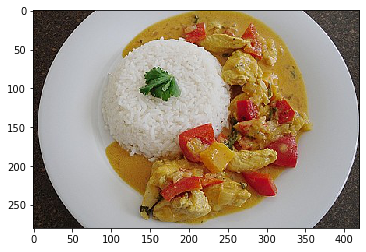

In [37]:
img_path = '../../data/imgs_fixed_100/african-chicken/african-chicken0.jpg'
img=mpimg.imread(img_path)
plt.imshow(img)

### Resizing image to fit the input size of VGG

In [38]:
from keras.applications.resnet50 import preprocess_input
img = image.load_img(img_path, target_size=(280, 420))

### Convert to numpy array

In [39]:
x = image.img_to_array(img)

### Reshape data so that it is in "batch" form because the model only accepts input in this form

In [40]:
import numpy as np
x = np.expand_dims(x, axis=0)

### "Batch" form

In [41]:
x.shape

(1, 280, 420, 3)

### Preprocessing

In [42]:
from keras.applications.resnet50 import preprocess_input
x = preprocess_input(x)

In [43]:
x

array([[[[ -68.939   ,  -74.779   ,  -66.68    ],
         [ -71.939   ,  -75.779   ,  -68.68    ],
         [ -75.939   ,  -79.779   ,  -72.68    ],
         ...,
         [ -43.939003,  -51.779   ,  -49.68    ],
         [ -52.939003,  -60.779   ,  -58.68    ],
         [ -41.939003,  -49.779   ,  -47.68    ]],

        [[ -80.939   ,  -86.779   ,  -78.68    ],
         [ -85.939   ,  -91.779   ,  -83.68    ],
         [ -81.939   ,  -85.779   ,  -78.68    ],
         ...,
         [ -38.939003,  -45.779   ,  -45.68    ],
         [ -41.939003,  -48.779   ,  -48.68    ],
         [ -44.939003,  -51.779   ,  -51.68    ]],

        [[ -77.939   ,  -83.779   ,  -75.68    ],
         [ -69.939   ,  -75.779   ,  -67.68    ],
         [ -78.939   ,  -84.779   ,  -76.68    ],
         ...,
         [ -36.939003,  -43.779   ,  -45.68    ],
         [ -49.939003,  -56.779   ,  -58.68    ],
         [ -54.939003,  -61.779   ,  -63.68    ]],

        ...,

        [[ -88.939   ,  -94.779   ,  -

### Prediction

In [56]:
import pandas as pd
from keras.applications.resnet50 import decode_predictions
preds = model.predict(x)
predictions = pd.DataFrame(preds).iloc[:,1:]
print('PREDICTION:',predictions)

PREDICTION:         1             2         3         4         5             6    \
0  0.000001  1.102400e-07  0.000005  0.995468  0.000178  6.408035e-07   

            7         8             9         10   ...       174       175  \
0  5.037348e-07  0.000005  1.712499e-07  0.000001  ...  0.000083  0.000004   

            176           177           178       179           180       181  \
0  1.216019e-08  3.505923e-07  8.802251e-08  0.000001  3.646995e-07  0.000004   

            182           183  
0  7.428912e-08  9.756087e-07  

[1 rows x 183 columns]


In [57]:
import seaborn as sns
f = sns.barplot(x='probability',y='category',data=predictions,color="red")
sns.set_style(style='white')
f.grid(False)
f.spines["top"].set_visible(False)
f.spines["right"].set_visible(False)
f.spines["bottom"].set_visible(False)
f.spines["left"].set_visible(False)
f.set_title('Top 3 Predictions:')

ModuleNotFoundError: No module named 'seaborn'

### Index of the prediction

In [58]:
argmax = np.argmax(preds[0])

### Get the index of the prediction

In [59]:
output = model.output[:, argmax]

### Model Archtecture

In [60]:
model.layers_by_depth

AttributeError: 'Model' object has no attribute 'layers_by_depth'

### We want to get the final Convolutional Layer

In [61]:
last_conv_layer = model.get_layer('res5c_branch2a')

### Get the Gradient

In [62]:
grads = K.gradients(output, last_conv_layer.output)[0]

### Each entry of this tensor is the mean intensity of the gradient over a specific feature map channel. This has a shape of (512,)

In [63]:
pooled_grads = K.mean(grads, axis=(0, 1, 2))

### Access the values of the quantities we just defined

In [64]:
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

### These are the values of these two quantities, as Numpy arrays, given our sample image of two elephants

In [65]:
pooled_grads_value, conv_layer_output_value = iterate([x])

### We multiply each channel in the feature map array by "how important this channel is" with regard to the elephant class

In [66]:
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

### Plotting the Heatmap

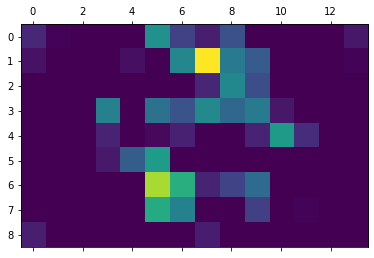

In [67]:
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

### Load Image with CV2

In [69]:
import cv2
img = cv2.imread(img_path)

### Resize the heatmap

In [70]:
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

### Convert heatmap to RGB

In [71]:
heatmap = np.uint8(255 * heatmap)

### Apply heatmap to original Image

In [72]:
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

### Apply heatmap intensity factor

In [73]:
hif = .8

In [74]:
superimposed_img = heatmap * hif + img

### Save to disk

In [76]:
output = 'output.jpeg'
cv2.imwrite(output, superimposed_img)

img=mpimg.imread(output)

### Plot

KeyError: 'category'

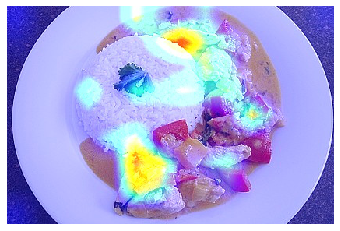

In [77]:
plt.imshow(img)
plt.axis('off')
plt.title(predictions.loc[0,'category'])

### Putting it all in a single funtion

In [30]:
from keras.applications.vgg16 import VGG16
    import matplotlib.image as mpimg
    from keras import backend as K
    import matplotlib.pyplot as plt
    import keras
    from keras.layers import Dense, Activation, Flatten, Dropout
    from keras.models import Sequential, Model

HEIGHT,WIDTH = 280,420
NUM_CLASSES = 184

model = keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(HEIGHT, WIDTH, 3))

def build_finetune_model(base_model, num_classes):
    x = base_model.output
    x = Flatten()(x)
    #
    # New FC layer, random init
    x = Dense(1024, activation='relu')(x)
    x = Dropout(rate = .6)(x)
    x = Dense(1024, activation='relu')(x)
    # New softmax layer
    predictions = Dense(num_classes, activation='softmax')(x)
    finetune_model = Model(inputs=base_model.input, outputs=predictions)
    return finetune_model
model = build_finetune_model(model, num_classes=NUM_CLASSES)
model.load_weights('../weights100_2fc_30e_54nt_32b.h5')

def cam(img_path):
    from keras.applications.vgg16 import VGG16
    import matplotlib.image as mpimg
    from keras import backend as K
    import matplotlib.pyplot as plt
    import keras
    from keras.layers import Dense, Activation, Flatten, Dropout
    from keras.models import Sequential, Model

    %matplotlib inline
    K.clear_session()

In [115]:
def cam(img_path):
    img=mpimg.imread(img_path)
    plt.imshow(img)
    from keras.preprocessing import image
    from keras.applications.resnet50 import preprocess_input
    img = image.load_img(img_path, target_size=(280, 420))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    from keras.applications.vgg16 import preprocess_input
    x = preprocess_input(x)
    preds = model.predict(x)
    argmax = np.argmax(preds[0])
    output = model.output[:, argmax]
    last_conv_layer = model.get_layer('res5c_branch2b')
    grads = K.gradients(output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    for i in range(512):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    import cv2
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    hif = .8
    superimposed_img = heatmap * hif + img
    output = 'muffin.png'
    cv2.imwrite(output, superimposed_img)
    img=mpimg.imread(output)
    plt.imshow(img)
    plt.axis('off')
    return None

### Trying it out on other images

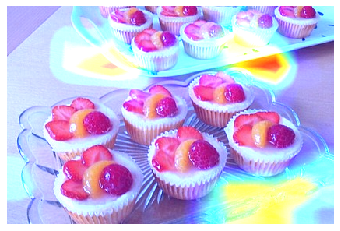

In [121]:
cam('../../data/imgs_fixed_100/bagels-grundrezept/bagels-grundrezept2.jpg')

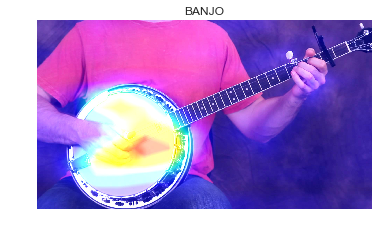

In [32]:
cam('G:/sample2.jpg')

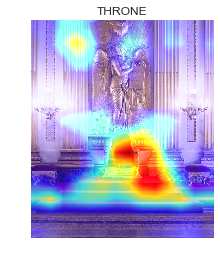

In [33]:
cam('G:/sample3.jpg')

### Using it on the same Category

As we expected, the CNN is looking for specific features. In the example below, when it sees this kind of nose/mouth area of a dog the models predicts that it is a greater swiss mountain dog.

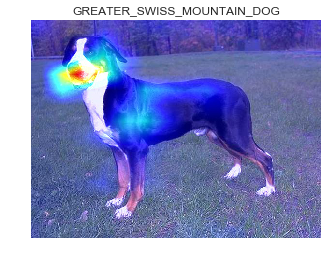

In [34]:
cam('G:/greater_swiss_mountain_dog.jpg')

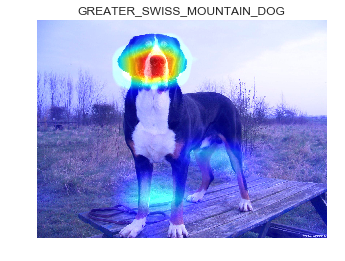

In [35]:
cam('G:/greater_swiss_mountain_dog4.jpg')

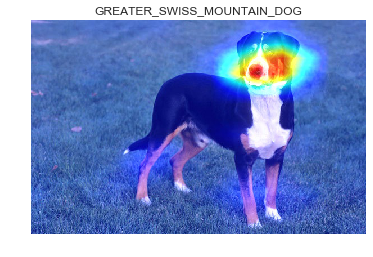

In [36]:
cam('G:/greater_swiss_mountain_dog2.jpg')

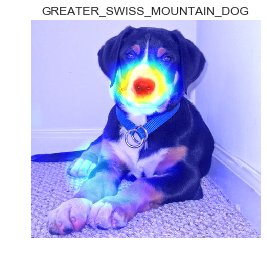

In [37]:
cam('G:/greater_swiss_mountain_dog3.jpg')

### Dogs

It is interesting what the model is looking for in order to identfy the breed of the dog.

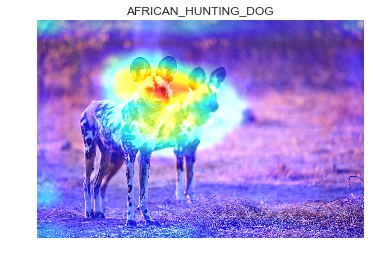

In [38]:
cam('G:/african_hunting_dog.jpg')

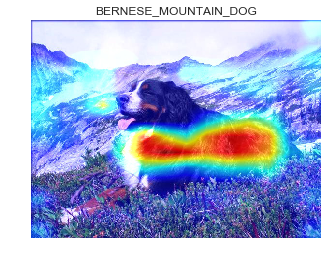

In [39]:
cam('G:/bernese_mountain_dog.jpg')

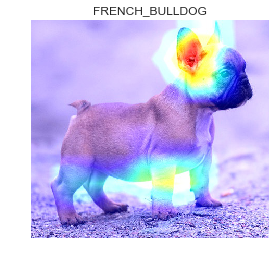

In [40]:
cam('G:/french_bulldog2.jpg')

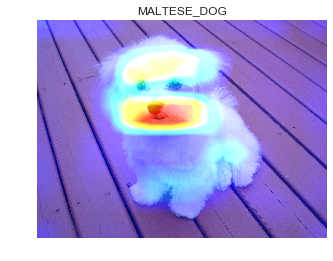

In [41]:
cam('G:/Maltese_puppy.jpeg')